In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models.efficientnet import *

In [2]:
seed = 777

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
data_path = Path('./chest_xray').absolute()
model_path = Path('./model').absolute()

In [4]:
pneumonia_stats = ([0.356352, 0.501708, 0.338671], [0.265587, 0.249634, 0.274386])

data = ImageDataBunch.from_folder(data_path,
                                  valid = 'test',
                                  size=300,
                                  ds_tfms=get_transforms(),
                                  resize_method = ResizeMethod.SQUISH,
                                 ).normalize(pneumonia_stats)

print(data.classes, len(data.train_ds), len(data.valid_ds))

['BACTERIA', 'NORMAL', 'VIRUS'] 5232 624


In [5]:
model = EfficientNet.from_pretrained('efficientnet-b3')
model

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [6]:
model._fc = nn.Linear(1536, 3)

In [7]:
learn = Learner(data, 
                model,
                bn_wd=False,
                metrics=error_rate,
                loss_func=LabelSmoothingCrossEntropy(),
                callback_fns=[BnFreeze,
                              partial(SaveModelCallback, monitor='error_rate', name='best_error')
                             ],
               ).to_fp16()

In [8]:
learn.split(lambda m: (model._conv_head,))
learn.freeze()

In [9]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.766745,1.350750,0.682692,00:50
1,0.703764,1.051602,0.375000,00:50
2,0.668456,0.811709,0.270833,00:50
3,0.636473,0.850282,0.290064,00:50
4,0.609334,0.709682,0.193910,00:49


Better model found at epoch 0 with error_rate value: 0.682692289352417.
Better model found at epoch 1 with error_rate value: 0.375.
Better model found at epoch 2 with error_rate value: 0.2708333432674408.
Better model found at epoch 4 with error_rate value: 0.19391025602817535.


In [10]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


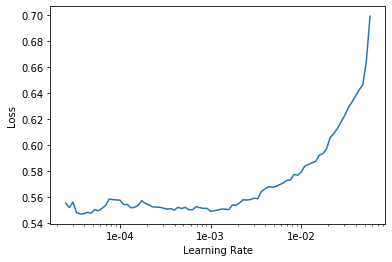

In [12]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, max_lr=5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.618299,0.667042,0.201923,00:59
1,0.606909,0.620419,0.157051,00:58
2,0.560151,0.552863,0.126603,00:59
3,0.498165,0.592331,0.147436,00:59
4,0.453720,0.566561,0.136218,00:59


Better model found at epoch 0 with error_rate value: 0.20192307233810425.
Better model found at epoch 1 with error_rate value: 0.15705128014087677.
Better model found at epoch 2 with error_rate value: 0.12660256028175354.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


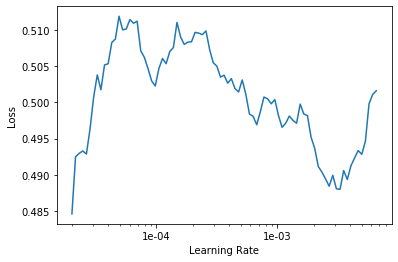

In [12]:
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-3, 1e-2))
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(25, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000)

epoch,train_loss,valid_loss,error_rate,time
0,0.499064,0.517339,0.108974,00:59
1,0.459685,0.586743,0.161859,01:00
2,0.440989,0.605970,0.152244,00:58
3,0.413653,0.654656,0.195513,00:58
4,0.402075,0.647595,0.189103,00:59
5,0.389935,0.681901,0.192308,00:59
6,0.375793,0.634579,0.174679,00:59
7,0.369057,0.593262,0.158654,01:00
8,0.360287,0.612766,0.161859,01:00
9,0.353973,0.605468,0.160256,00:59


Better model found at epoch 0 with error_rate value: 0.10897435992956161.
